In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

# Calculates Whiff Rate for all of dft
league_average_whiff_rate = total_misses / total_swings

# Create a new dataframe with only pitches that are Splitters
dfsp = dft[(dft['Pitch Type'] == 'Splitter')]

# Handle NA values
dfsp.fillna(dfsp.mean(), inplace=True)

dfsp['Extension Pow'] = pow(dfsp['Extension'], 3) + pow(dfsp['Extension'], 2) 
dfsp['Differential Break^3'] = pow(dfsp['Differential Break'], 3) 
dfsp['Release Height^2'] = pow(dfsp['Release Height'], 2)
dfsp['Induced Vertical Break^2'] = pow(dfsp['Release Height'], 2)

# Filter to only include swings
dfsp_swing = dfsp[(dfsp['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-2-63bd376cf3bd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-2-63bd376cf3bd>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [3]:
dfsp[['Velocity', 'Spin Rate', 'Release Height', 'Release Side', 'Extension', 'Horizontal Break', 'Differential Break', 'Induced Vertical Break']].corr()

,Velocity,Spin Rate,Release Height,Release Side,Extension,Horizontal Break,Differential Break,Induced Vertical Break
Velocity,1.000000,0.259590,0.390873,0.142949,-0.047370,0.367302,0.003305,0.252824
Spin Rate,0.259590,1.000000,-0.177012,0.511857,0.222954,0.251811,-0.104849,0.148886
Release Height,0.390873,-0.177012,1.000000,-0.187670,-0.206422,0.190718,-0.024749,0.264825
Release Side,0.142949,0.511857,-0.187670,1.000000,0.603050,0.282090,-0.156368,0.199313
Extension,-0.047370,0.222954,-0.206422,0.603050,1.000000,0.119518,-0.044542,-0.094220
Horizontal Break,0.367302,0.251811,0.190718,0.282090,0.119518,1.000000,0.073377,0.230164
Differential Break,0.003305,-0.104849,-0.024749,-0.156368,-0.044542,0.073377,1.000000,-0.175791
Induced Vertical Break,0.252824,0.148886,0.264825,0.199313,-0.094220,0.230164,-0.175791,1.000000


In [4]:
# Linear regression Model

X = dfsp_swing[['Velocity', 'Spin Rate', 'Release Height^2', 'Release Side', 'Extension Pow', 'Horizontal Break', 'Differential Break^3', 'Induced Vertical Break^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsp_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.20890039680659123
Linear Regression R-squared score: 0.1643984127736351


In [5]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                          importance
Spin Rate                   0.253736
Horizontal Break            0.147551
Release Height^2            0.028286
Induced Vertical Break^2    0.028286
Extension Pow              -0.076091
Differential Break^3       -0.112204
Velocity                   -0.139766
Release Side               -0.244997


In [6]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.22875
Random Forest R-squared score: 0.08499999999999996


In [7]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                          importance
Extension Pow               0.209734
Release Side                0.154710
Differential Break^3        0.135984
Horizontal Break            0.121420
Spin Rate                   0.116830
Velocity                    0.102616
Induced Vertical Break^2    0.086662
Release Height^2            0.072044


In [8]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.3583116813994739
XGBoost R-squared score: -0.43324672559789557


In [9]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                          importance
Extension Pow               0.263108
Differential Break^3        0.252345
Release Height^2            0.157811
Velocity                    0.108003
Spin Rate                   0.099455
Release Side                0.079194
Horizontal Break            0.040084
Induced Vertical Break^2    0.000000


In [10]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.22629750373223317
R-squared score: 0.0948099850710673


In [11]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

1/1 [==============================] - 0s 206ms/step
Mean Squared Error: 0.2620417030372537
R-squared score: -0.04816681214901486


In [12]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

1/1 [==============================] - 0s 37ms/step


In [13]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

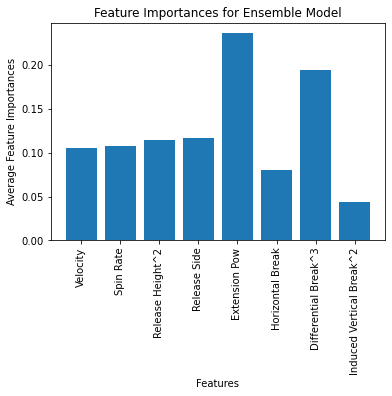

In [14]:
features_list = ['Velocity', 'Spin Rate', 'Release Height^2', 'Release Side', 'Extension Pow', 'Horizontal Break', 'Differential Break^3', 'Induced Vertical Break^2']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [15]:
X = dfsp[['Velocity', 'Spin Rate', 'Release Height^2', 'Release Side', 'Extension Pow', 'Horizontal Break', 'Differential Break^3', 'Induced Vertical Break^2']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfsp['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

4/4 [==============================] - 0s 3ms/step


In [17]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

1/1 [==============================] - 0s 40ms/step


In [18]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [19]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [20]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [21]:
# Calculate the 'Stuff+' values
dfsp['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-21-20f1ef708b02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfsp['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [22]:
dfsp['Stuff+'].describe()

count    130.000000
mean     100.000000
std       50.186464
min      -14.026339
25%       59.470861
50%       90.715943
75%      141.983494
max      216.324781
Name: Stuff+, dtype: float64

In [23]:
dfsp.head(30)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,Extension Pow,Differential Break^3,Release Height^2,Induced Vertical Break^2,Stuff+
3100,Brett Wichrowski,Splitter,InPlay,WAR_GAT,Jacob Corson,COT_KET,Right,90.40474,2457.281985,5.37782,...,GroundBall,Undefined,7.98702,0,1,227.087372,509.511881,28.920948,28.920948,62.712433
6452,Ben Peterson,Splitter,InPlay,CHA_ANG,Zack Stewart,WAR_GAT,Right,88.57172,1007.893419,5.91141,...,GroundBall,Undefined,11.29686,0,1,166.726252,1441.694494,34.944768,34.944768,48.753818
6481,Ben Peterson,Splitter,BallCalled,CHA_ANG,Joshua Stevenson,WAR_GAT,Right,87.01898,944.905695,5.95648,...,Undefined,Undefined,4.61118,0,0,189.285158,98.047433,35.479654,35.479654,45.130389
6484,Ben Peterson,Splitter,FoulBall,CHA_ANG,Joshua Stevenson,WAR_GAT,Right,88.36214,922.897208,5.98535,...,Undefined,Undefined,8.13926,0,0,189.671344,539.206061,35.824415,35.824415,52.741658
6486,Ben Peterson,Splitter,BallinDirt,CHA_ANG,Joshua Stevenson,WAR_GAT,Right,88.67214,1091.443352,5.94795,...,Undefined,Undefined,4.38627,0,0,177.209028,84.389047,35.378109,35.378109,53.481579
6523,Ben Peterson,Splitter,InPlay,CHA_ANG,Caleb Pendleton,WAR_GAT,Right,88.22717,880.546118,5.94277,...,GroundBall,Undefined,7.68425,0,1,194.745575,453.737274,35.316515,35.316515,42.866822
6565,Aeden Finateri,Splitter,InPlay,CHA_ANG,Nick McLain,WAR_GAT,Right,78.56626,1277.712240,5.17289,...,GroundBall,Undefined,8.35831,0,1,247.899191,583.922787,26.758791,26.758791,37.998426
6568,Aeden Finateri,Splitter,BallCalled,CHA_ANG,David Glancy,WAR_GAT,Right,77.51771,1150.197477,5.09298,...,Undefined,Undefined,10.27765,0,0,245.558733,1085.629090,25.938445,25.938445,31.749698
6612,Aeden Finateri,Splitter,BallinDirt,CHA_ANG,David Glancy,WAR_GAT,Right,77.89241,1459.007885,5.09679,...,Undefined,Undefined,4.04819,0,0,259.540196,66.341099,25.977268,25.977268,65.930838
7178,Mitchell Voit,Splitter,StrikeCalled,YAR_RED,Kennedy Jones,HAR_MAR,Right,78.15007,1601.617784,5.76368,...,Undefined,Undefined,5.55752,0,0,146.730217,171.649721,33.220007,33.220007,182.928858


In [24]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfsp_sorted = dfsp.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfsp_sorted.reset_index(drop=True, inplace=True)

dfsp_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,Extension Pow,Differential Break^3,Release Height^2,Induced Vertical Break^2,Stuff+
0,Chad Gartland,Splitter,FoulBall,ORL_FIR,III Tibbs,BRE_WHI,Right,82.46489,3096.141717,4.72741,...,Undefined,Undefined,4.02969,0,0,191.721170,65.435724,22.348405,22.348405,216.324781
1,Chad Gartland,Splitter,StrikeSwinging,ORL_FIR,Ike Irish,BRE_WHI,Right,82.78183,3100.228811,4.74809,...,Undefined,Undefined,11.73741,1,1,192.896212,1617.025340,22.544359,22.544359,213.271730
2,Hector Garcia,Splitter,StrikeSwinging,YAR_RED,Joshua Kuroda-Grauer,BOU_BRA,Right,76.53430,1309.033799,5.81985,...,Undefined,Strikeout,3.17606,1,1,134.887545,32.038051,33.870654,33.870654,211.048809
3,Mitchell Voit,Splitter,StrikeCalled,YAR_RED,Kennedy Jones,HAR_MAR,Right,78.21556,1809.294030,5.73527,...,Undefined,Undefined,5.65488,0,0,160.664225,180.829874,32.893322,32.893322,205.768688
4,Mitchell Voit,Splitter,StrikeCalled,YAR_RED,Kennedy Jones,HAR_MAR,Right,78.15007,1601.617784,5.76368,...,Undefined,Undefined,5.55752,0,0,146.730217,171.649721,33.220007,33.220007,182.928858
5,Matthew Fernandez,Splitter,BallCalled,YAR_RED,Carson Benge,CHA_ANG,Right,79.23582,1395.226195,5.94381,...,Undefined,Undefined,5.29946,0,0,174.805209,148.831499,35.328877,35.328877,181.006027
6,Matthew Fernandez,Splitter,StrikeSwinging,YAR_RED,Matthew Etzel,CHA_ANG,Right,79.84767,1596.981537,5.79338,...,Undefined,Undefined,8.37618,1,1,171.111746,587.676067,33.563252,33.563252,180.275209
7,Mitchell Voit,Splitter,BallCalled,YAR_RED,Kennedy Jones,HAR_MAR,Right,78.11223,1741.532406,5.70530,...,Undefined,Undefined,0.79953,0,0,142.886694,0.511098,32.550448,32.550448,180.051372
8,Chad Gartland,Splitter,StrikeSwinging,ORL_FIR,III Tibbs,BRE_WHI,Right,82.04568,2617.269259,4.80057,...,Undefined,Strikeout,0.56004,1,1,192.556845,0.175654,23.045472,23.045472,179.239739
9,Matthew Fernandez,Splitter,FoulBall,YAR_RED,Kaeden Kent,CHA_ANG,Right,79.66630,1522.719314,5.83025,...,Undefined,Undefined,0.20264,0,0,168.930697,0.008321,33.991815,33.991815,173.621411


In [25]:
average_spl_Stuff = dfsp[dfsp['Pitch Type'] == 'Splitter'].groupby('Pitcher')['Stuff+'].mean()
average_spl_Stuff = average_spl_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_spl_Stuff_sorted = average_spl_Stuff.sort_values(ascending=False)

average_spl_Stuff_sorted

Pitcher
Mitchell Voit        183.35
Hector Garcia        158.46
Matthew Fernandez    148.48
Kros Sivley          146.16
Brian Zeldin         143.32
Chase Hopewell       137.52
Jake Peppers         131.46
Hiroyuki Yamada      110.99
Austin Gordon         93.21
Chad Gartland         92.90
Liam Doyle            91.28
Reid Easterly         90.72
Josh Pyne             90.72
JB Middleton          84.80
Ben Jacobs            82.02
Matt Maloney          81.66
Brett Wichrowski      62.71
Nicholas Judice       58.05
Aeden Finateri        52.39
Ben Peterson          48.59
James Hepp           -14.03
Name: Stuff+, dtype: float64